In [10]:
import os
import urllib
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision

ds = torchvision.datasets.MNIST('./data')
image_shape = (1,28,28)

In [27]:

def show_examples(data, image_shape, n_start=None, n_end=None, n_cols=20, thumbnail_cb=None):
    n_start = n_start or 0
    n_end = n_end or len(data)

    if n_start >= n_end:
        raise ValueError("Must have n_start < n_end.")
    nump = n_end - n_start
    _, img_rows, img_cols = image_shape
    n_rows = int(np.ceil(nump / float(n_cols)))
    fig = np.zeros((img_rows * n_rows, img_cols * n_cols))

    for k in range(n_start, n_end):
        x = data[k][0] # image
        r = k // n_cols
        c = k % n_cols

        fig[r * img_rows:(r+1)*img_rows, c*img_cols:(c+1)*img_cols] = x

        if thumbnail_cb is not None:
            thumbnail_cb(locals())

    plt.figure(figsize=(12,10))
    plt.imshow(fig, cmap='gray')
    plt.axis('off')
    plt.tight_layout()


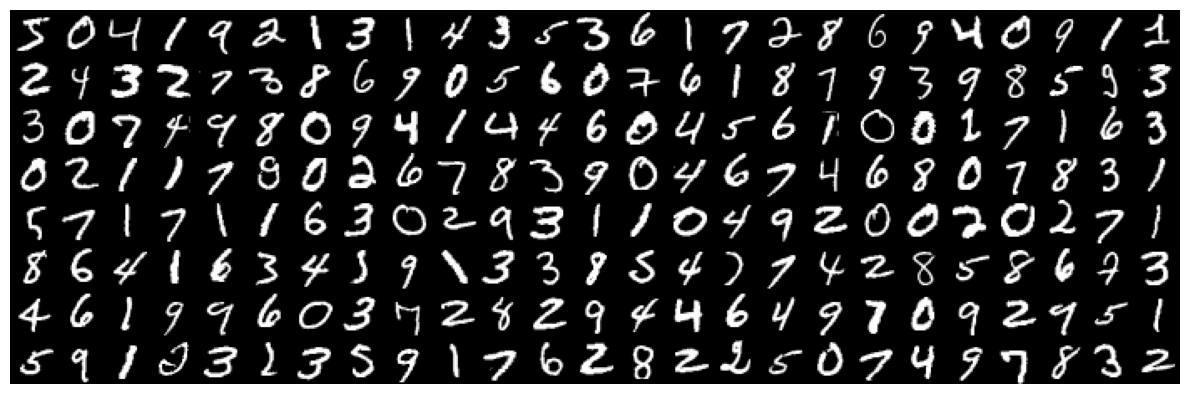

In [28]:
show_examples(ds, image_shape, n_end=200, n_cols=25)

In [29]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_shape, latent_dim, base_model):
        super().__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.base_model = base_model

        base_output_size = self._get_output_size()
        self.linear_latent = nn.Linear(base_output_size, latent_dim)

    def _get_output_size(self):
        # builds a dummy batch containing one dummy tensor
        # full of zeroes with the same shape as the inputs
        device = next(self.base_model.parameters()).device.type
        dummy = torch.zeros(1, *self.input_shape, device=device)
        # sends the dummy batch through the base model to get 
        # the output size produced by it
        size = self.base_model(dummy).size(1)
        return size

    def forward(self, x):
        base_output = self.base_model(x) # push through base model
        z = self.linear_latent(base_output) # get linear output in latent space
        return z

In [31]:
input_shape = (1, 28, 28)
latent_dim = 2

encoder_base_model = nn.Sequential(
    torch.nn.Conv2d(1,16,5,1,2),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.MaxPool2d(2,2),
    torch.nn.Conv2d(16, 32, 5, 1, 2),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(1), # retain batch dimension
    torch.nn.Linear(32*7*7, latent_dim),
)
encoder = Encoder(input_shape, latent_dim, encoder_base_model)

decoder = nn.Sequential(
    nn.Linear(latent_dim, 2048),
    nn.LeakyReLU(),
    torch.nn.Dropout(0.2),
    nn.Linear(2048, 2048),
    nn.LeakyReLU(),
    torch.nn.Dropout(0.2),
    nn.Linear(2048, np.prod(input_shape)),
    nn.Unflatten(1, input_shape),
    nn.Sigmoid(),
)


In [51]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

mnist_ds = torchvision.datasets.MNIST(root="./data", download=True, transform=transform)
mnist_dl = torch.utils.data.DataLoader(dataset=mnist_ds, batch_size=10, shuffle=True)

In [52]:
type(mnist_ds[0])

tuple

In [60]:
# inputs
# for batch in mnist_dl:
    # print(batch[0].max())
    # break
# ff_t = torch.tensor(ds, requires_grad=False).float().unsqueeze(1) / 255.0

# test forward pass
# ff_t_hat = encoder(mnist_dl)

tensor(1.)


Let's wrap the encoder and decoder together in a single object.

In [61]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

model_ae = AutoEncoder(encoder, decoder)

In [64]:

def plot_input_output(x, model):
    x = x[0]
    if x.ndim < 4:
        x = x.unsqueeze(0)
    x_hat = model(x)

    _, ax = plt.subplots(ncols=2, figsize=(8, 5))
    ax[0].imshow(x[0][0].detach().numpy(), cmap='gray')
    ax[1].imshow(x_hat[0][0].detach().numpy(), cmap='gray')
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

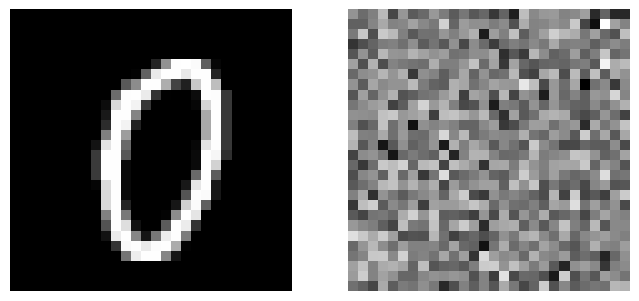

In [65]:
plot_input_output(mnist_ds[1000], model_ae)

In [66]:
# training loop
model_ae.train()
loss_function = nn.MSELoss() # poor choice for image?
optim = torch.optim.Adam(model_ae.parameters(), 0.0005)

num_epochs = 200
train_losses = []

for epoch in range(1, num_epochs+1):
    batch_losses = []
    for i, x in enumerate(mnist_dl):
        x = x[0]
        model_ae.train()
        
        x_hat = model_ae(x)
        loss = loss_function(x_hat, x)
        loss.backward()
        optim.step()
        optim.zero_grad()
        batch_losses.append(np.array([loss.data.item()]))

    train_losses.append(
        np.array(batch_losses).mean(axis=0)
    )
    if (epoch) % 10 == 0:
        print(f'Epoch {epoch:03d} | Loss >> {train_losses[-1][0]:.4f}')

Epoch 010 | Loss >> 0.0423
Epoch 020 | Loss >> 0.0414
Epoch 030 | Loss >> 0.0410
Epoch 040 | Loss >> 0.0407
Epoch 050 | Loss >> 0.0406
Epoch 060 | Loss >> 0.0404
Epoch 070 | Loss >> 0.0403
Epoch 080 | Loss >> 0.0402
Epoch 090 | Loss >> 0.0402
Epoch 100 | Loss >> 0.0405
Epoch 110 | Loss >> 0.0401
Epoch 120 | Loss >> 0.0400
Epoch 130 | Loss >> 0.0401
Epoch 140 | Loss >> 0.0400
Epoch 150 | Loss >> 0.0400
Epoch 160 | Loss >> 0.0400
Epoch 170 | Loss >> 0.0399
Epoch 180 | Loss >> 0.0400
Epoch 190 | Loss >> 0.0400
Epoch 200 | Loss >> 0.0400


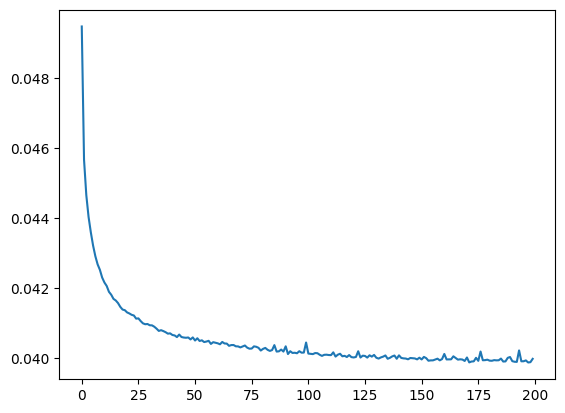

In [67]:
plt.plot(train_losses)

In [68]:

def plot_input_output(x, model):
    if x.ndim < 4:
        x = x.unsqueeze(0)
    x_hat = model(x)

    _, ax = plt.subplots(ncols=2, figsize=(8, 5))
    ax[0].imshow(x[0][0].detach().numpy())
    ax[1].imshow(x_hat[0][0].detach().numpy())
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

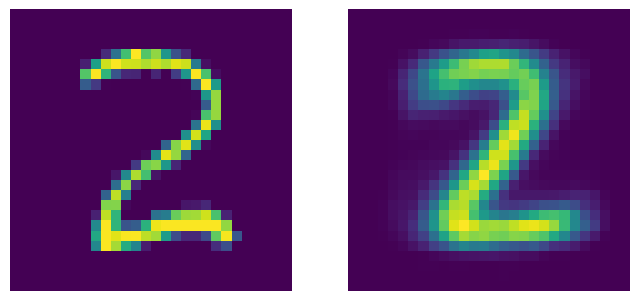

tensor([[-0.3395, -0.2837]], grad_fn=<AddmmBackward0>)


In [72]:
k = 1900
plot_input_output(mnist_ds[k][0], model_ae)

inp = mnist_ds[k][0].unsqueeze(0)
print(model_ae.encoder(inp))

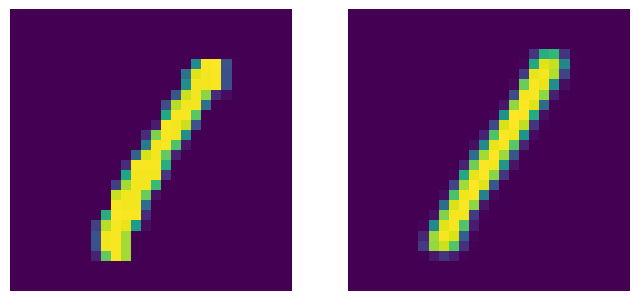

tensor([[-0.5289, -0.6003]], grad_fn=<AddmmBackward0>)


In [75]:
k = 3
plot_input_output(mnist_ds[k][0], model_ae)

inp = mnist_ds[k][0].unsqueeze(0)
print(model_ae.encoder(inp))

All the reconstructed images seem identical!

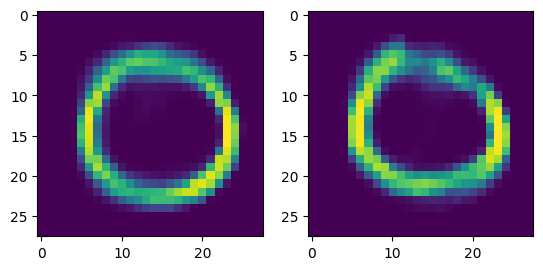

In [76]:
def generate(z: torch.tensor, model):
    x_hat = model.decoder(z)
    return x_hat.detach()


fig, ax = plt.subplots(ncols=2)

z = torch.tensor([[0.4, 0.25]])
x_hat = generate(z, model_ae)[0,0].detach()
ax[0].imshow(x_hat)

z = torch.tensor([[0.6, 0.25]])
x_hat = generate(z, model_ae)[0,0].detach()
ax[1].imshow(x_hat)



In [77]:
xt = torch.arange(-2.0, 1.0, step=0.1)

Y_t, X_t = torch.meshgrid(xt, xt)
n_dims = X_t.shape
X_t = X_t.flatten().unsqueeze(0).T
Y_t = Y_t.flatten().unsqueeze(0).T
Z_t = torch.concat([X_t, Y_t], axis=1)
# Z_t = Z_t.reshape((*n_dims, 2))
X_t_hat = model_ae.decoder(Z_t)

n_plot = np.prod(n_dims)

/home/DKS0559531/miniconda3/envs/torch/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


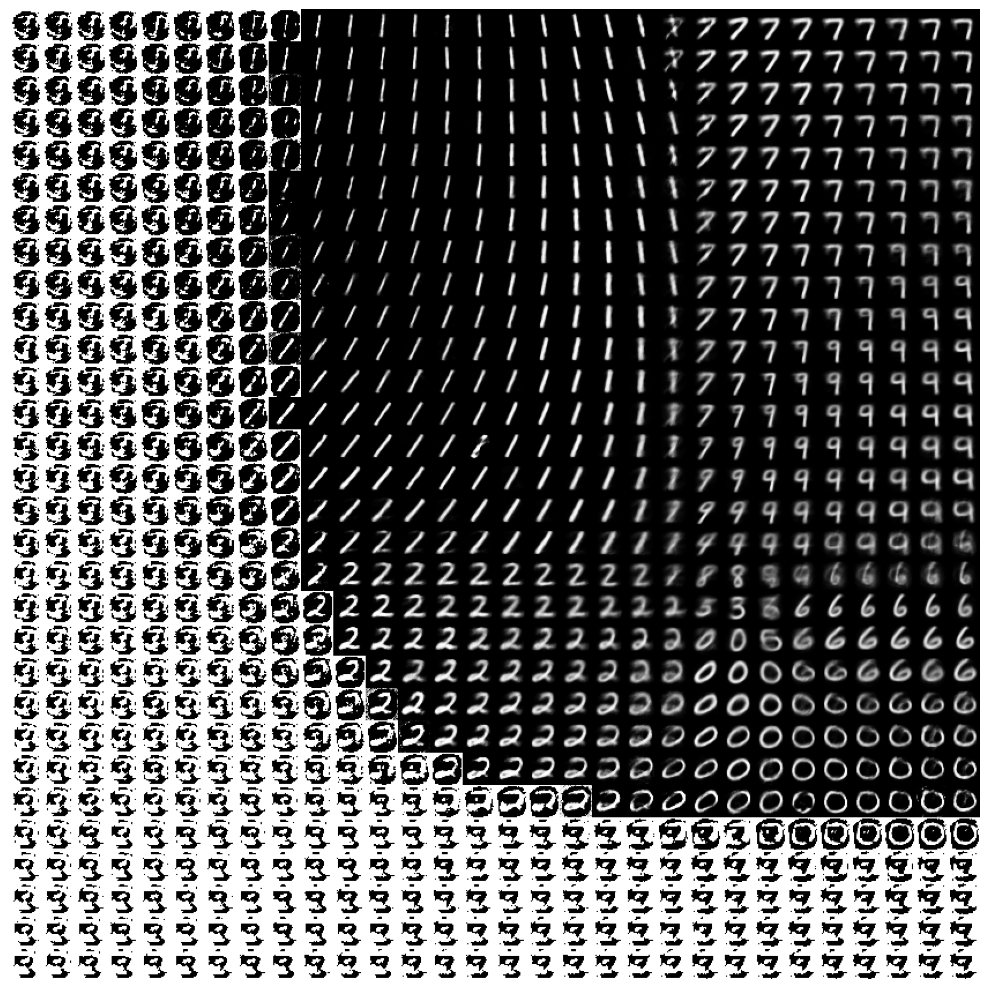

In [80]:
data = X_t_hat.detach().numpy()
img_rows, img_cols = 28, 28
n_rows = n_cols = int(np.sqrt(n_plot))

fig = np.zeros((img_rows * n_rows, img_cols * n_cols))

for k in range(n_plot):
    x = data[k,0]
    r = k // n_cols
    c = k % n_cols

    fig[r * img_rows:(r+1)*img_rows, c*img_cols:(c+1)*img_cols] = x

    # if thumbnail_cb is not None:
        # thumbnail_cb(locals())

plt.figure(figsize=(12,10))
plt.imshow(fig, cmap='gray')
plt.axis('off')
plt.tight_layout()

In [98]:
mnist_dl.batch_size

10

In [142]:
# 60,000 total examples
n_tot = 2_000
bs = mnist_dl.batch_size
n_batches = int(n_tot / bs)

for batch_idx, batch in enumerate(mnist_dl):
    x = batch[0]
    labs = batch[1]
    z = model_ae.encoder(x)
    if batch_idx == 0:
        z_all = z.detach()
        labels_all = labs.detach()
    else:
        z_all = torch.concat([z_all, z], axis=0)
        labels_all = torch.concat([labels_all, labs], axis=0)

    if batch_idx == n_batches-1:
        break

z_allp = z_all.detach().numpy()
c = labels_all.detach().numpy()

In [145]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10)
gmm.fit(z_allp)

gmm.means_

array([[ 2.12771869e-01, -1.39047974e-03],
       [-4.97795740e-01, -8.14091939e-01],
       [ 4.71000184e-01, -8.21467132e-01],
       [ 1.85976391e-01, -2.14390899e-01],
       [ 5.90300013e-01, -1.74281342e-01],
       [ 2.23560159e-01, -5.03690813e-01],
       [-5.58921367e-01, -1.76571512e+00],
       [ 3.22841455e-01, -1.36502548e+00],
       [ 1.60482650e+00, -3.56310787e-02],
       [-1.37551394e-01, -1.13461264e-01]])

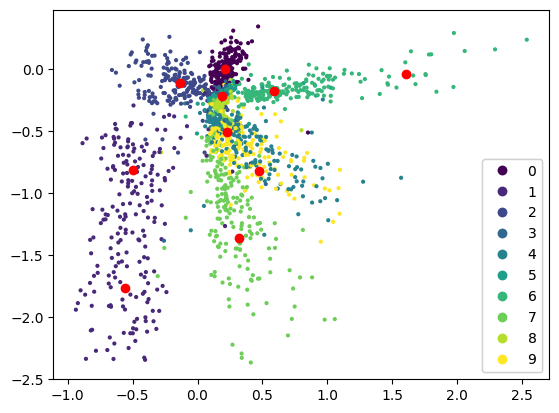

In [146]:
fig, ax = plt.subplots()

sc = ax.scatter(z_allp[:,0], z_allp[:,1], c=c, label=c, s=4)
ax.scatter(gmm.means_[:,0], gmm.means_[:,1])
leg1 = ax.legend(*sc.legend_elements())
ax.add_artist(leg1)
plt.show()

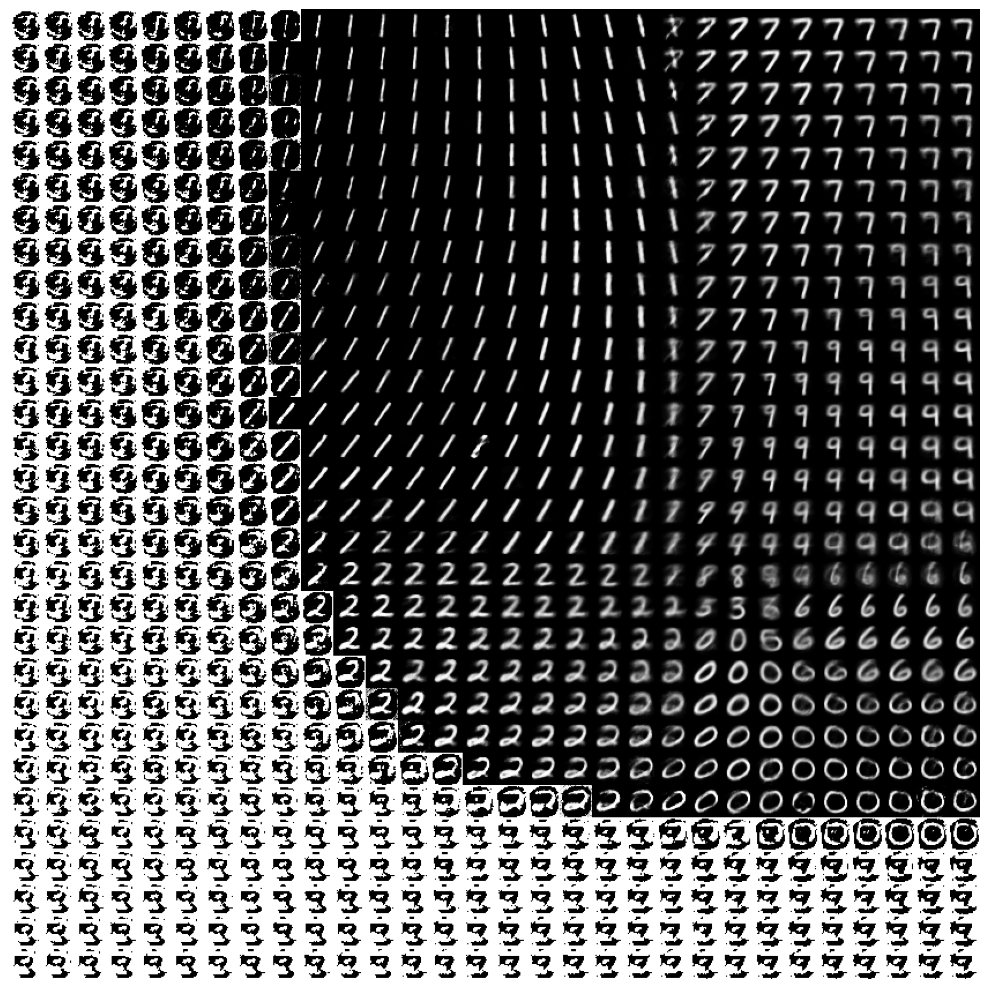

In [138]:
data = X_t_hat.detach().numpy()
img_rows, img_cols = 28, 28
n_rows = n_cols = int(np.sqrt(n_plot))

fig = np.zeros((img_rows * n_rows, img_cols * n_cols))

for k in range(n_plot):
    x = data[k,0]
    r = k // n_cols
    c = k % n_cols

    fig[r * img_rows:(r+1)*img_rows, c*img_cols:(c+1)*img_cols] = x

    # if thumbnail_cb is not None:
        # thumbnail_cb(locals())

plt.figure(figsize=(12,10))
plt.imshow(fig, cmap='gray')
plt.axis('off')
plt.tight_layout()